# CQA Random Forest Prediction 
In this code file, we have converted the original code scheme of LASSO regression to a simple random forest classification scheme. 
In addition, there is a bug in the original code for backtesting that we fixed as well.
Modified code sections are highlighted with red captions.(Color highlighter can be installed via the Jupyter nbextension package: https://jupyter-contrib-nbextensions.readthedocs.io/en/latest/nbextensions/highlighter/readme.html).

delayed return  
84_Q data

In [8]:
#Import packages 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import platform
platform.architecture()

('64bit', 'WindowsPE')

### import alpha library

In [9]:
# read data
data_matrix1 = pd.read_csv("C:\\Users\\tony\\Desktop\\CQA\\data\\data_matrix_20_Q.csv")
data_matrix2 = pd.read_csv("C:\\Users\\tony\\Desktop\\CQA\\data\\data_matrix_21_to_40_Q.csv")
data_matrix3 = pd.read_csv("C:\\Users\\tony\\Desktop\\CQA\\data\\data_matrix_41_to_60_Q.csv")
data_matrix4 = pd.read_csv("C:\\Users\\tony\\Desktop\\CQA\\data\\data_matrix_61_to_84_Q.csv")

In [10]:
data_matrix = pd.concat([data_matrix1,data_matrix2,data_matrix3,data_matrix4],ignore_index=True)

### monthly return

In [11]:
monthly_returns = data_matrix[['asOfDate','tic','Return']]

In [12]:
tics = data_matrix['tic']
dates = data_matrix['asOfDate']
dates = dates.apply(lambda x: x[:7])

## 1. Data preprocess

separate dates, returns (label) and alphas (data) from data matrix

In [13]:
mask = [i for i in range(14,488)]
alpha_library = data_matrix.iloc[:,mask]
alpha_library.head()

,ALPHA_77,ALPHA_267,ALPHA_505,ALPHA_572,ALPHA_25,SPPIVY,ALPHA_129,ALPHA_264,OPMBD,OPMBD1,...,IBCOMY,DOQ,DOY,IBADJQ,IBQ,IBADJY,IBY,CSH12Q,CSHPRQ,CSHPRY
0,-0.129319,0.053984,0.306399,0.346287,-0.066755,14.0,0.000000,2.028620,0.287070,0.287070,...,9705.0,0.0,0.0,3253.0,3253.0,9705.0,9705.0,905.3295,912.197,907.762
1,-0.273262,-0.003845,0.233960,-0.231986,-0.166918,-771.0,1.056310,-1.211370,0.295827,0.295827,...,5617.0,0.0,0.0,2741.0,3123.0,5331.0,6305.0,9102.1828,9956.773,9570.166
2,-0.323743,0.103459,0.204940,0.259946,1.604720,-1061.0,1.980420,-0.135714,0.300105,0.300105,...,6917.0,-3.0,208.0,2674.0,2700.0,6860.0,6917.0,23195.6250,28849.400,28646.900
3,-0.055053,0.058377,0.426733,2.559450,-0.082981,NaN,0.536183,0.816442,0.414490,0.414490,...,18760.0,0.0,0.0,4518.0,4518.0,18760.0,18760.0,8813.0000,8712.000,8813.000
4,-0.127456,0.058582,0.412080,1.127290,-0.024606,0.0,0.000000,1.159110,0.396041,0.396041,...,3795.0,0.0,0.0,1840.0,1840.0,3795.0,3795.0,317.4950,318.350,318.123


### Function1: delete columns with too many nan 
input:    
data -- dataframe;   
ratio -- threshold of (number of NA's)/(data size);
      
output:    
data -- dataframe which the ratio less than threshold ratio

In [14]:
# delete columns with too many nan
def delete_columns_with_too_many_nan(data, ratio):
    return data.loc[:,data.isnull().mean()<(ratio)]

After delete all the alpha with >0.1 NA's, the alpha library contains 464 alphas.

In [15]:
alpha_library = delete_columns_with_too_many_nan(alpha_library, 0.1)
alpha_library.shape

(252000, 474)

### Function2: replace NA's with mean in the column

In [16]:
# replace nan with mean
def replace_nan_with_mean(data):
    col_names = list(data)
    col_mean = np.nanmean(data, axis=0)
    values = {}
    for i in range(len(col_names)):
        values[col_names[i]] = col_mean[i]
    return data.fillna(values)

In [17]:
alpha_library = replace_nan_with_mean(alpha_library)

### Function3: data mask
input:   
start_year,start_quarter,train_time,delay

output:   
training data

In [18]:
def monthly_delay(start_year,start_month,delay):
    if start_month<10:
        start_time = str(start_year)+'-0'+str(start_month)
    else:
        start_time = str(start_year)+'-'+str(start_month)    
    
    response_month = start_month+delay
    if response_month>12:
        response_year = start_year+1
        response_month = response_month-12
    else:
        response_year = start_year
        
    if response_month<10:
        response_time = str(response_year)+'-0'+str(response_month)
    else:
        response_time = str(response_year)+'-'+str(response_month)
        
    return start_time,response_time


<div class="burk">
    At this point, if we just leave the code as it is, then testing set would be the same as the training set. 
    In other words, train_x would be in the same period as test_x, while train_Y would be in the same period as test_Y.
    And thus the backtesting would be invalid..
    
    Therefore, we have proposed to roll over the testing dataset one month, and the following convert_to_test function implements this goal.
</div><i class="fa fa-lightbulb-o "></i>

In [19]:

def convert_to_test(start_year,start_month,delay):
    #normal addition process
    #if start_month <12:
    if start_month <9:
        start_yr = start_year
        #start_m = start_month +1
        start_m = start_month +delay
        
    #adding another year
    else: 
        start_yr = start_year + 1 
        #start_m = 1 
        start_m = start_month + delay - 12
    
    return start_yr, start_m 


In [20]:
def retrive_train(alpha_library,monthly_returns,dates,tics,start_year,start_month,delay):
    start_time,response_time = monthly_delay(start_year,start_month,delay)
    
    train_mask = dates == start_time
    train_alpha  = alpha_library[train_mask]
    train_tic = list(tics[train_mask])
    
    ###
    response_mask = dates == response_time
    response_return = monthly_returns['Return'][response_mask]
    response_tic = monthly_returns['tic'][response_mask]

    # create a tic-return dictionary
    response_dict = dict([(i,j) for i,j in zip(response_tic,response_return)])

    # create returns
    train_Y = np.zeros([train_alpha.shape[0],1])
    for i in range(len(train_tic)):
        if train_tic[i] in response_dict:
            train_Y[i] = response_dict[train_tic[i]]
        else:
            train_Y[i] = None
            
    train_Y = pd.DataFrame(train_Y)
    
    # filter nan in returns
    train_alpha['label'] = train_Y.values
    train_Y = train_alpha.loc[~train_alpha['label'].isnull(),'label']
    train_X = train_alpha.loc[~train_alpha['label'].isnull(),].drop(columns=['label'])

    return train_X,train_Y

In [21]:
def retrive_test(alpha_library,monthly_returns,dates,tics,start_year,start_month,delay):
    start_time,response_time = monthly_delay(start_year,start_month,delay)
    ###
    test_mask = dates == start_time
    test_X  = alpha_library[test_mask]
    test_tic = list(tics[test_mask])

    return test_X,test_tic,response_time

## 2. Random Forest regression

In [22]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
import warnings
warnings.filterwarnings('ignore')

In [23]:
#import data files
import os 
returns_folder = "C:\\Users\\tony\\Desktop\\CQA\\data\\dr\\"
files_list = os.listdir(returns_folder)
files_list = sorted(files_list)

There are two different strategy for the portfolio management.   
(1) invest one (or negetive one) dollar every day for each company  
(2) invest one(or negetive one) dollar in the beginning of every month for each company  

The following function is based on assumption (2).

In [24]:
def portfolio_monthly_returns(date,files_list,returns_folder,returns,x):
    daily_returns = pd.DataFrame([], columns=('date','portfolio_value','portfolio_return'))
    i = 0
    for temp_file in files_list:
        if date in temp_file:
            return_temp = pd.read_csv(returns_folder+temp_file)
            return_temp = return_temp.dropna()
        
            for j in range(return_temp.shape[0]):
                if return_temp.iloc[j,0] in returns:
                    comp_tic = return_temp.iloc[j,0]
                    returns[comp_tic] = returns[comp_tic]*(1+return_temp.iloc[j,1])
            daily_returns.loc[i] = [pd.Timestamp(temp_file[:10]),x+sum(returns.values()),None]
            if i>0:
                daily_returns['portfolio_return'][i] = (daily_returns['portfolio_value'][i]-daily_returns['portfolio_value'][i-1])/daily_returns['portfolio_value'][i-1]
            else:
                daily_returns['portfolio_return'][i] = (daily_returns['portfolio_value'][i]-x)/x
            i = i+1
    month_return = (daily_returns['portfolio_value'][i-1]-x)/x

    return daily_returns,month_return 

<div class="burk">
    The following iterative algorithm performs a backtesting of Random Forest Prediction based on the specified dataset.s
    We have include the convert_to_test function to roll over testing set one month, to fix the bug in the code.
    
</div><i class="fa fa-lightbulb-o "></i>

In [25]:
from sklearn.ensemble import RandomForestClassifier

delay = 4 # delay
m = 1500 # number_of_stocks
portfolio_returns = pd.DataFrame([], columns=('date','portfolio_return'))
portfolio_daily_returns = pd.DataFrame([], columns=('date','portfolio_value','portfolio_return'))
i = 0
set_dates = list(sorted(set(dates)))
x = 1
#for k in range(len(set_dates)-delay):
#for k in range(len(set_dates)-delay-1):
for k in range(len(set_dates)-delay-delay):
    date = set_dates[i]
    start_year = int(date[:4])
    start_month = int(date[5:7])
    
    train_X,train_Y = retrive_train(alpha_library,monthly_returns,dates,tics,start_year,start_month,delay)
    #test_X,test_tic,response_time = retrive_test(alpha_library,monthly_returns,dates,tics,start_year,start_month,delay)
    
    ###############################################
    ##############################################
    ##############################################
    #roll over the relationship one period ahead, to fix the bug
    start_y, start_m = convert_to_test(start_year,start_month,delay)
    test_X,test_tic,response_time = retrive_test(alpha_library,monthly_returns,dates,tics,start_y,start_m,delay)
    ################################################
    ################################################
    ###############################################

    #convert to binary return of Buy/sell
    train_Y = np.where(train_Y > np.repeat(0, len(train_Y)), "Buy","Sell")

    #create random forest object
    rf = RandomForestClassifier()
    # Train the model on training data
    rf.fit(train_X, train_Y);
    #make predictions using testing set 
    pred_Y_rf = rf.predict(test_X)
    
    #long the stocks that classify as Buy, and short the stocks that classify as sell
    companies = test_tic
    pred = dict(zip(companies, pred_Y_rf))

    #create an equal weighted dollar-neutral portfolio#
    
    #number of longing stocks in the dollar-neutral portfolio
    ls = np.where(pred_Y_rf == 'Buy', 1,0)
    nl = sum(ls)
    
     #number of shorting stocks in the dollar-neutral portfolio
    ss = np.where(pred_Y_rf == 'Sell',1,0)
    ns = sum(ss)
    
    returns = {}
    for j in companies:
        if pred[j] == 'Buy':
            returns[j] = x/nl/2
        else: 
            returns[j] = -x/ns/2

    
    #calculate monthly portfolio return
    daily_returns,portfolio_return = portfolio_monthly_returns(response_time,files_list,returns_folder,returns,x)
    print('portfolio_return for',response_time, 'is ',portfolio_return)
    
    portfolio_daily_returns = pd.concat([portfolio_daily_returns, daily_returns], ignore_index=True)
    portfolio_returns.loc[i] = [pd.Timestamp(response_time),portfolio_return]
    i = i+1
    x = daily_returns.iloc[-1,1]

portfolio_return for 2011-05 is  0.005259231623340188
portfolio_return for 2011-06 is  0.01257541928316422
portfolio_return for 2011-07 is  -0.0008087966022396766
portfolio_return for 2011-08 is  0.0033767231353075008
portfolio_return for 2011-09 is  0.007844401561804108
portfolio_return for 2011-10 is  0.0023860036994668814
portfolio_return for 2011-11 is  5.47446863912463e-05
portfolio_return for 2011-12 is  -0.002837760646312245
portfolio_return for 2012-01 is  0.014540563412683812
portfolio_return for 2012-02 is  -0.00013582509606075514
portfolio_return for 2012-03 is  0.011327495722335015
portfolio_return for 2012-04 is  0.002510300318641784
portfolio_return for 2012-05 is  -0.007959913913255755
portfolio_return for 2012-06 is  -0.0011093148406460373
portfolio_return for 2012-07 is  0.006210557604297865
portfolio_return for 2012-08 is  0.00021374518888158246
portfolio_return for 2012-09 is  -0.013995649609519505
portfolio_return for 2012-10 is  0.005699162093866223
portfolio_retur

Portfolio 

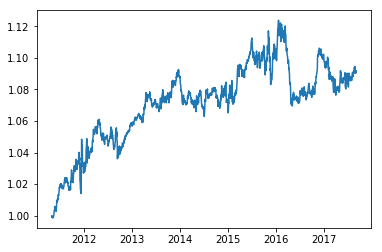

In [26]:
aggregate = [1]
for i in portfolio_daily_returns['portfolio_return']:
    aggregate.append(aggregate[-1]*(i+1))
aggregate = aggregate[1:]
plt.plot(portfolio_daily_returns['date'],aggregate)

In [27]:
portfolio_daily_returns = portfolio_daily_returns.set_index(portfolio_daily_returns['date'])

## 3. output

In [41]:
def mean_return(returns):
    return 252*np.mean(returns)*100
    
def vol(returns):
    return np.sqrt(252)*np.std(returns)*100

def sharpe_ratio(returns):
    return np.sqrt(252)*np.mean(returns)/np.std(returns)

def Sortino(returns):
    return np.sqrt(252)*np.mean(returns)/np.std(returns[returns<0])

def draw_down(returns):
    # We are going to use a trailing 252 trading day window
    window = 252
    # Calculate the max drawdown in the past window days for each day in the series.
    # Use min_periods=1 if you want to let the first 252 days data have an expanding window
    #Roll_Max = pd.rolling_max(returns, window, min_periods=1)
    
    Roll_Max = returns.rolling(window,min_periods = 1).max()
    Daily_Drawdown = returns/Roll_Max - 1.0

    # Then we calculate the minimum daily drawdown, which is equivalent to maximum drawdown 
    # Again, use min_periods=1 if you want to allow the expanding window
    #Max_Daily_Drawdown = pd.rolling_min(Daily_Drawdown, window, min_periods=1)
    Max_Daily_Drawdown = Daily_Drawdown.rolling(window,min_periods = 1).min()
    return Max_Daily_Drawdown
    

In [47]:
for year in range(2011,2017):
    returns = portfolio_daily_returns[str(year)+'-01-01':str(year+1)+'-01-01']['portfolio_return']
    #print(len(returns))
    print(draw_down(returns)[-1])
    print('year %4d, mean return = %.4f, Volatility = %.4f, sharpe ratio = %.4f, Max_Drawdown Rate = %.4f, Sortino ratio = %.4f' % \
          (year,mean_return(returns),vol(returns),sharpe_ratio(returns),draw_down(returns)[-1],Sortino(returns)))

-3.1904791294488803
year 2011, mean return = 4.1393, Volatility = 3.9640, sharpe ratio = 1.0442, Max_Drawdown Rate = -3.1905, Sortino ratio = 1.2788
-2.9847768223888425
year 2012, mean return = 2.9904, Volatility = 2.9947, sharpe ratio = 0.9986, Max_Drawdown Rate = -2.9848, Sortino ratio = 1.2880
-2.272647009671036
year 2013, mean return = 2.7740, Volatility = 2.2667, sharpe ratio = 1.2238, Max_Drawdown Rate = -2.2726, Sortino ratio = 1.7779
-7.930414450473524
year 2014, mean return = -1.5474, Volatility = 2.6333, sharpe ratio = -0.5876, Max_Drawdown Rate = -7.9304, Sortino ratio = -0.9157
-2.0120566610720285
year 2015, mean return = 2.9798, Volatility = 3.8615, sharpe ratio = 0.7717, Max_Drawdown Rate = -2.0121, Sortino ratio = 1.1444
-1.9422908392234541
year 2016, mean return = -0.4121, Volatility = 3.0278, sharpe ratio = -0.1361, Max_Drawdown Rate = -1.9423, Sortino ratio = -0.2142


<div class="burk">
Once we have fix the bug, total portfolio return is positive! 
    Please note that we haven't used any future information at each step of the iterative backtest. (this is a common error in backtesting!).
</div><i class="fa fa-lightbulb-o "></i>

In [48]:
aggregate[-1]-1

0.09177618620860595